# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Conv2D, MaxPooling2D,Dropout,InputLayer,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.efficientnet import preprocess_input
import os

# Loading the Dataset and Performing Initial Analysis

We begin by specifying the directory path containing the training images and loading the corresponding labels from the CSV file. The dataset is read using `pandas` and basic information about the dataset, such as column types and non-null values, is displayed using the `info()` method. Finally, the class distribution of the target variable (age group) is computed and displayed.

In [2]:
image_dir= Path('/kaggle/input/faces-age-detection-dataset/faces/Train')
dd = pd.read_csv('/kaggle/input/faces-age-detection-dataset/faces/train.csv')
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB


In [3]:
class_counts = dd['Class'].value_counts()
class_counts

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

# Ploting Pie Chart

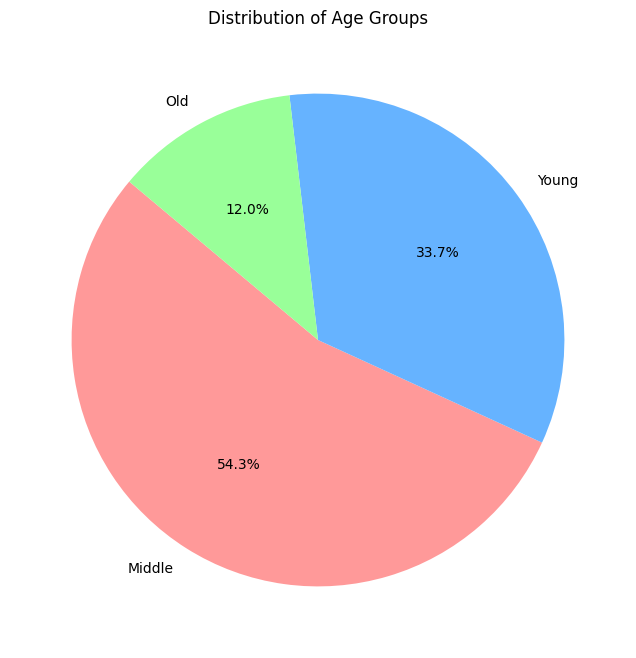

In [4]:
# Plotting the pie chart
lab = ['Middle','Young','Old']
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=lab, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Age Groups')
plt.show()


### Constructing a DataFrame of Image Paths and Labels

This code block creates a DataFrame that maps image file paths to their corresponding labels:

- **Dictionary Mapping**: 
  - A dictionary (`label_dict`) is created by zipping the `ID` (image file names) and `Class` (labels) columns from the dataset.
  
- **Data Collection**:
  - Two lists, `file_names` and `labels`, are initialized to store image file paths and labels.
  - The code iterates over image files in the `image_dir`, checking if the file name exists in the `label_dict`. If it does, the corresponding label and file path are stored in their respective lists.

- **DataFrame Creation**:
  - A DataFrame (`df`) is created with two columns: "image" for file paths and "label" for the corresponding class labels.
  
- **Shape Verification**:
  - The shape of the resulting DataFrame is printed to confirm the number of records.

This process efficiently organizes image data and labels for subsequent analysis or model training.


In [5]:
# Create a dictionary mapping file names to labels
label_dict = dict(zip(dd['ID'], dd['Class']))

# Initialize lists to store file paths and corresponding labels
file_names = []
labels = []

# Iterate through all image files and collect paths and labels
for file in tqdm(sorted(image_dir.glob('*.*'))):
    label_file = file.name  # Extract the file name
    if label_file in label_dict:
        labels.append(label_dict[label_file])  # Get label from dictionary
        file_names.append(str(file))  # Store the file path

# Create a DataFrame from the collected data
df = pd.DataFrame({"image": file_names, "label": labels})

# Print the shape of the DataFrame
print(df.shape)

100%|██████████| 19906/19906 [00:00<00:00, 215629.13it/s]

(19906, 2)


In [6]:
df.head()

,image,label
0,/kaggle/input/faces-age-detection-dataset/face...,MIDDLE
1,/kaggle/input/faces-age-detection-dataset/face...,OLD
2,/kaggle/input/faces-age-detection-dataset/face...,MIDDLE
3,/kaggle/input/faces-age-detection-dataset/face...,MIDDLE
4,/kaggle/input/faces-age-detection-dataset/face...,YOUNG


In [ ]:
# label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
# df['target'] = df['label'].map(label_mapping)
# df.head()

In [7]:
file_names[:5]

['/kaggle/input/faces-age-detection-dataset/faces/Train/0.jpg',
 '/kaggle/input/faces-age-detection-dataset/faces/Train/1.jpg',
 '/kaggle/input/faces-age-detection-dataset/faces/Train/100.jpg',
 '/kaggle/input/faces-age-detection-dataset/faces/Train/10000.jpg',
 '/kaggle/input/faces-age-detection-dataset/faces/Train/10001.jpg']

In [8]:
labels[:5]

['MIDDLE', 'OLD', 'MIDDLE', 'MIDDLE', 'YOUNG']

## Showing Some images from dataset

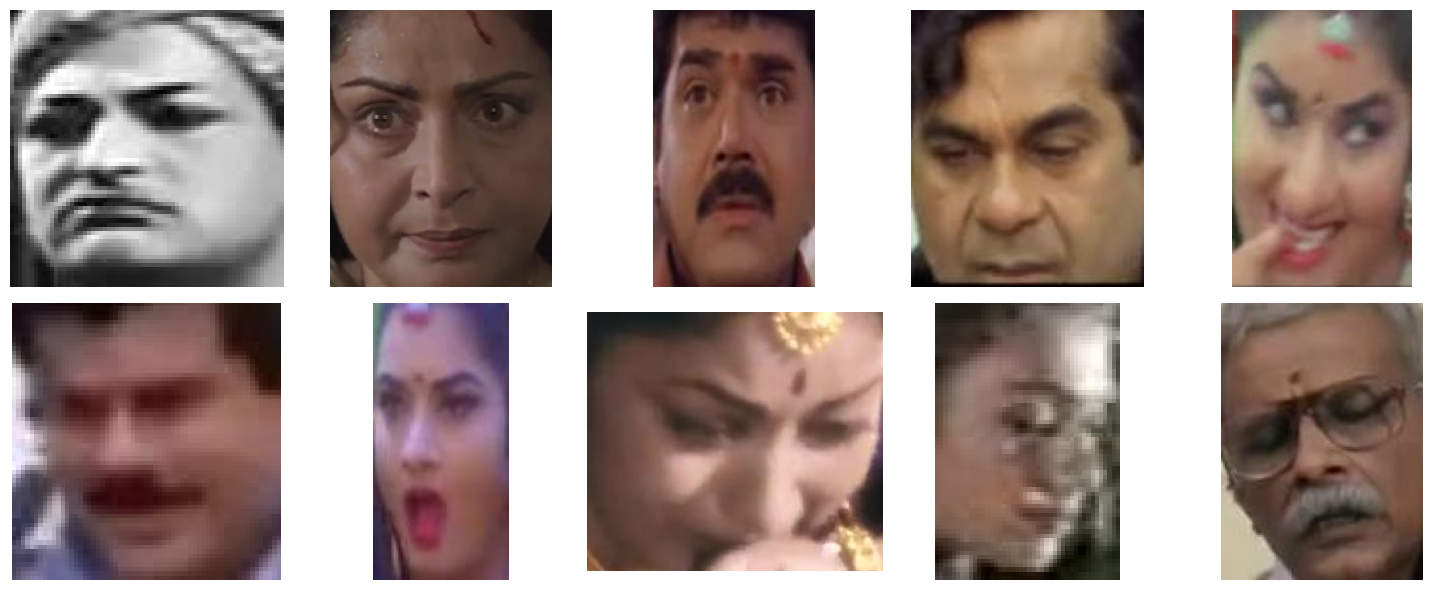

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img = Image.open(df['image'][i])
    row =i//5
    col =i% 5
    axes[row,col].imshow(img)
    axes[row,col].axis('off')
plt.tight_layout()
plt.show()

## Spliting Dataset into Train_Test

In [10]:
# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print('Length of Train Data :',len(train_df))
print('Length of Validation Data :',len(val_df))
print(train_df.head())

Length of Train Data : 15924
Length of Validation Data : 3982
                                                   image   label
16375  /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
6644   /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
2314   /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
13336  /kaggle/input/faces-age-detection-dataset/face...   YOUNG
19079  /kaggle/input/faces-age-detection-dataset/face...   YOUNG


In [11]:
print(type(train_df['label']))
train_df['label'] = train_df['label'].astype(str)  # Ensure labels are strings
val_df['label'] = val_df['label'].astype(str)


<class 'pandas.core.series.Series'>


In [12]:
type(val_df)

pandas.core.frame.DataFrame

# Data Augmentation and ImageDataGenerator Setup

In this section, two `ImageDataGenerator` objects are defined for the training and validation datasets:

- **Training Data Generator (`train_datagen`)**:
  - Applies several augmentation techniques to enhance model generalization:
    - **Rescale**: Normalizes pixel values by dividing by 255.
    - **Rotation**: Random rotations up to 20 degrees.
    - **Shifts**: Random width and height shifts up to 20%.
    - **Shear**: Random shear transformations.
    - **Zoom**: Random zoom up to 20%.
    - **Flip**: Random horizontal flips.
    - **Fill Mode**: Fills in gaps from transformations using the nearest pixel.

- **Validation Data Generator (`val_datagen`)**:
  - Only rescales pixel values by dividing by 255.

- **Data Generators**:
  - `train_generator`: Batches of augmented training images (224x224 pixels) and categorical labels, with a batch size of 32.
  - `val_generator`: Batches of validation images with the same parameters but no augmentation.

These generators efficiently feed data into the model during training and validation.


In [13]:
# Define the ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 15924 validated image filenames belonging to 3 classes.
Found 3982 validated image filenames belonging to 3 classes.


In [14]:
# Ensuring the Data Availability
print("Number of batches in train generator:", len(train_generator))
print("Number of batches in validation generator:", len(val_generator))

#Debug the Training Process
for data_batch, label_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break


Number of batches in train generator: 498
Number of batches in validation generator: 125
Data batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


# Model Architecture and Compilation

The model is built using the pre-trained **EfficientNetB0** as the base model, leveraging transfer learning with ImageNet weights:

- **Base Model**: 
  - EfficientNetB0 is loaded with pre-trained ImageNet weights.
  - The top classification layer is excluded (`include_top=False`).
  - Only the last 20 layers are set as trainable to fine-tune the model, while the rest are frozen to retain pre-trained features.

- **Custom Layers**:
  - A **Global Average Pooling** layer is added after the base model to reduce the dimensionality of the feature maps.
  - A **Dropout** layer with a 50% dropout rate is used for regularization to prevent overfitting.
  - A final **Dense** layer with 3 units and a softmax activation function is added to predict the 3 age categories (young, middle, old).

- **Model Compilation**:
  - The model is compiled using the **Adam optimizer** with a learning rate of 0.001.
  - **Categorical Crossentropy** is chosen as the loss function for multi-class classification.
  - **Accuracy** is selected as the evaluation metric.


In [15]:
def create_model():
    # Load and configure the base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [16]:
# Compile the  Model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# model = Sequential()

# # Add the InputLayer to specify the input shape
# model.add(InputLayer(shape=(224, 224, 3)))

# # Add normalization after the input
# model.add(BatchNormalization())
# # Add subsequent layers
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'),)
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# # Add normalization after the Flatten
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(3, activation='softmax')) 

# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

# Train The Model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss : {val_loss:.2f} \n Validation Accuracy: {val_accuracy:.2f}')

In [ ]:
model.save_weights('age_detection_model_weights.weights.h5')

In [ ]:
from IPython.display import FileLink

FileLink(r'age_detection_model_weights.weights.h5')

# Visualizing Loss And Accuracy

In [17]:
# Extract loss and accuracy metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()


NameError: name 'history' is not defined

In [ ]:
model = create_model()
model.load_weights('/kaggle/input/model-weights/age_detection_model_weights.weights.h5')

# Preprocess input And Prediction

In [ ]:
# Step 4: Load and preprocess the input image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to match EfficientNetB0 input
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for EfficientNetB0
    return img_array

# Step 5: Predict the age group of the input image
def predict_image_age(image_path):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    
    # Assuming your labels were [0: young, 1: middle, 2: old]
    age_classes = ['young', 'middle', 'old']
    
    predicted_class = np.argmax(prediction, axis=1)
    predicted_age_group = age_classes[predicted_class[0]]
    
    return predicted_age_group

# Example prediction
image_path = '/kaggle/input/imagedata/download.jpeg'  # Replace with the path to the image you want to predict
predicted_age_group = predict_image_age(image_path)
print(f'The predicted age group is: {predicted_age_group}')